In [1]:
import shapely
from shapely.geometry import LinearRing, LineString, Point
from numpy import sin, cos, pi, sqrt
from random import random

import numpy as np
from matplotlib import pyplot as plt

In [56]:
# A prototype simulation of a differential-drive robot with one sensor

# Constants

R = 0.021  # radius of wheels in meters
L = 0.094  # distance between wheels in meters

W = 1.18  # width of arena
H = 1.94  # height of arena

robot_timestep = 0.1        # 1/robot_timestep equals update frequency of robot
simulation_timestep = 0.01  # timestep in kinematics sim (probably don't touch..)

# the world is a rectangular arena with width W and height H
world = LinearRing([(W/2,H/2),(-W/2,H/2),(-W/2,-H/2),(W/2,-H/2)])

# Variables 
###########

x = 0   # robot position in meters - x direction - positive to the right 
y = 0   # robot position in meters - y direction - positive up
q = 0.0   # robot heading with respect to x-axis in radians 

left_wheel_velocity =  random()   # robot left wheel velocity in radians/s
right_wheel_velocity =  random()  # robot right wheel velocity in radians/s

# Sensor measurements
##################

# central sensor: robot starts 80mm in front 0.008
# side sensors: robot starts 78mm in front 0.0078

# Kinematic model
#################
# updates robot position and heading based on velocity of wheels and the elapsed time
# the equations are a forward kinematic model of a two-wheeled robot - don't worry just use it
def simulationstep():
    global x, y, q

    for step in range(int(robot_timestep/simulation_timestep)):     #step model time/timestep times
        v_x = cos(q)*(R*left_wheel_velocity/2 + R*right_wheel_velocity/2) 
        v_y = sin(q)*(R*left_wheel_velocity/2 + R*right_wheel_velocity/2)
        omega = (R*right_wheel_velocity - R*left_wheel_velocity)/(2*L)    
    
        x += v_x * simulation_timestep
        y += v_y * simulation_timestep
        q += omega * simulation_timestep

# Simulation loop
#################
file = open("trajectory.dat", "w")


for cnt in range(10000):
    #simple single-ray sensor
    ray_L = LineString([(x, y), (x+cos(q-(np.pi/4))*2*W,(y+sin(q-(np.pi/4))*2*H)) ])  # a line from robot to a point outside arena in direction of q
    ray_C = LineString([(x, y), (x+cos(q)*2*W,(y+sin(q)*2*H)) ])  # a line from robot to a point outside arena in direction of q
    ray_R = LineString([(x, y), (x+cos(q+(np.pi/4))*2*W,(y+sin(q+(np.pi/4))*2*H)) ])  # a line from robot to a point outside arena in direction of q
    rays = [ray_R,ray_C,ray_L]
    min_distance = 100 #dummy large number
    for i,ray in enumerate(rays):
        s = world.intersection(ray)
        distance = sqrt((s.x-x)**2+(s.y-y)**2)
        if distance < min_distance:
            min_distance = distance
            direction = i # if direction is 0, obstacle sensed Left. If 1, obstacle straight ahead. If 2, obstacle to the right.
            # distance to wall
    
    #simple controller - change direction of wheels every 10 seconds (100*robot_timestep) unless close to wall then turn on spot
    if (distance < 0.15): # OBSTACLE SENSED. #TODO: input sensor distance from robot centre (80 mm)
        if direction == 0: # Obstacle to left. turn right
            left_wheel_velocity = 0.4
            right_wheel_velocity = -0.4
            
        if direction == 1: # obstacle ahead. turn right
            left_wheel_velocity = -0.4 # Original code. If delete, keep this
            right_wheel_velocity = 0.4
            
        if direction == 2: #obstacle to the right. turn left
            left_wheel_velocity = -0.4 
            right_wheel_velocity = 0.4

    else:                
        if cnt%100==0:
            speed = random()
            left_wheel_velocity = speed
            right_wheel_velocity = speed
        
    #step simulation
    simulationstep()

    #check collision with arena walls 
    if (world.distance(Point(x,y))<L/2):
        break
        
    if cnt%50==0:
        file.write( str(x) + ", " + str(y) + ", " + str(cos(q)*0.05) + ", " + str(sin(q)*0.05) + "\n")

file.close()

In [57]:
# load data from file into numpy
data = np.loadtxt('trajectory.dat', delimiter=", ")
print(data)

[[ 1.92106755e-03  0.00000000e+00  5.00000000e-02  0.00000000e+00]
 [ 9.79744448e-02  0.00000000e+00  5.00000000e-02  0.00000000e+00]
 [ 1.93624887e-01  0.00000000e+00  5.00000000e-02  0.00000000e+00]
 [ 2.69531490e-01  0.00000000e+00  5.00000000e-02  0.00000000e+00]
 [ 3.44257618e-01  0.00000000e+00  5.00000000e-02  0.00000000e+00]
 [ 3.61140501e-01  0.00000000e+00  5.00000000e-02  0.00000000e+00]
 [ 3.79548519e-01  0.00000000e+00  5.00000000e-02  0.00000000e+00]
 [ 4.72688150e-01  0.00000000e+00  5.00000000e-02  0.00000000e+00]
 [ 5.13669587e-01  0.00000000e+00  4.84429880e-02  1.23805053e-02]
 [ 5.13669587e-01  0.00000000e+00  3.83378869e-02  3.20968290e-02]
 [ 5.13669587e-01  0.00000000e+00  2.07055789e-02  4.55113063e-02]
 [ 5.13669587e-01  0.00000000e+00 -9.92033456e-04  4.99901577e-02]
 [ 5.12889876e-01  1.58283105e-03 -2.20949426e-02  4.48532442e-02]
 [ 4.73904334e-01  8.07243834e-02 -2.20949426e-02  4.48532442e-02]
 [ 4.34796687e-01  1.60113811e-01 -2.20949426e-02  4.48532442e

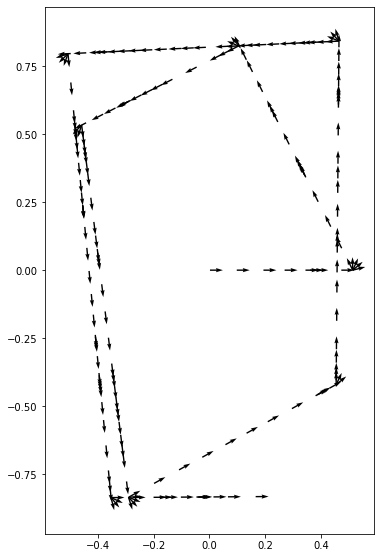

In [58]:
f, ax = plt.subplots(1,1, figsize=(W*5,H*5))
ax.set_xlim(-W/2, W/2)
ax.set_ylim(-H/2, H/2)

ax.quiver(data[:,:1], data[:,1:2], data[:,2:3], data[:,3:4])

plt.show()